## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
%%capture
!pip install seaborn==0.9.0

In [2]:
import glob
import os

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [3]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [4]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [5]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = filename.split('/')[-1].strip('.npz')

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata['subject'] == subject]['age'].values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata['subject'] == subject]['sex'].values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [6]:
df.head()

,age_group,sex,rhr
0,60-64,Female,89.302326
1,65-69,Male,65.641026
2,45-49,Male,56.928458
3,60-64,Male,68.571429
4,50-54,Male,84.395604


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

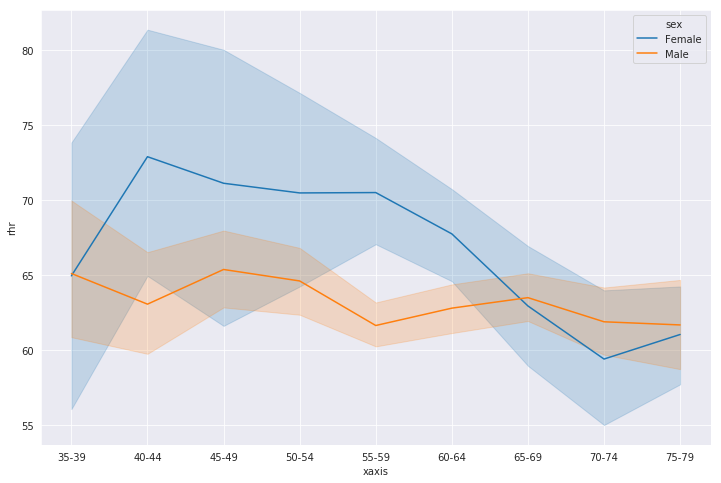

In [7]:
labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

In [8]:
df.sex.value_counts()

Male      1260
Female     277
Name: sex, dtype: int64

Text(0.5,1,'Count by Age Group, Gender')

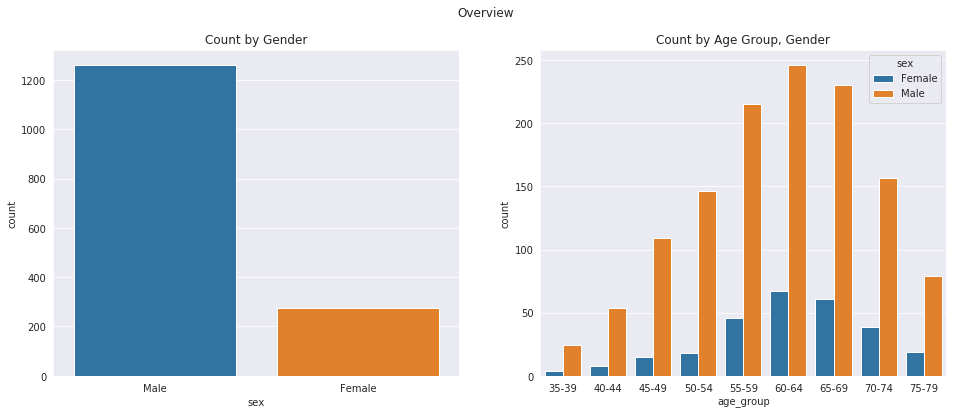

In [9]:
figure, axes = plt.subplots(1, 2, figsize=(16,6))
figure.suptitle('Overview')
sns.countplot(ax=axes[0], data=df, x='sex',
              order=df.sex.value_counts().index)
axes[0].set_title('Count by Gender')
sns.countplot(ax=axes[1], data=df, x='age_group', hue='sex',
              order=['35-39','40-44','45-49','50-54','55-59','60-64','65-69', '70-74', '75-79'])
axes[1].set_title('Count by Age Group, Gender')

### Clinical Conclusion

For women, we see a notable increase in resting heart rate (RHR) from the ages 35-39 to ages 40-44, a slight decline for the ages 40-44 to 55-59, and a steep decline from 55-59 to 70-74. RHRss are very variable (relatively larger confidence interval) for the ages below 55.

For men, we see small increase in RHR around ages 45-49, with a declining trend into old ages. We also observe lower variation in heart rates for the age groups of 25 to 79 years relative to women.

In comparison to men, women have a higher average RHR for the ages 35-39 to 65-69 for men, although the variation for women of age group 45-49 can drop below the average RHR for men. While RHR in men seems to have a steady declining downward trend with age, we see a steeper decline for women.

There may be several possible reasons for these observations.
* We have far less female (277) than male (1260) data. Smaller sample size naturally comes with higher variation.
* Distribution from both groups are slightly left skewed with most samples present around the middle ages (55-69). This is due to CAST data collected from people with acute myocardial infarction (MI) within the preceding 2 years of the collection time, which is more common in middle age and elderly people.
* Women typically have higher RHRs, peaking around the ages of 40-49 ([source](https://healthsolutions.fitbit.com/blog/resting-heart-rate/)).

There are several ways we may be able to improve results.
* We may be able to improve our results with a bigger and more representative dataset that includes more Females and more people from the younger age groups.
* Factors affecting RHR include: weight, air temperature, body position, medication, sleep and stress.
* There is a correlation between RHR and a person's Body Mass Index (BMI). We don't have weight data available, but this could prove to be a valuable source of added information.
* Higher temperature and humidity increases RHR. Data should be carefully collected at similar if not same temperature and humidity conditions

We cannot validate the trend that average RHR increases up until middle age and decreases into older age. We have an insufficient sample size with underrepresented groups and should, thus, refrain from making any conclusions.